In [ ]:
"""
# points는 2000 * 2 배열

* tf.constant()를 사용한 상수 생성
* tf.variable()를 사용한 상수 생성

[상수를 생성하는 방법들]
tf.constant() #함수 인수로 지정된 값 이용
tf.zeros_like # 모든 원소 0 초기화
tf.ones_like # 모든 원소 1 초기화
tf.fill # 주어진 스칼라 값으로 원소 초기화

[탠서 생성관련 함수] * 생성할 텐서의 차원의 구조를 매개변수로 입력받아야함.
tf.random_normal # 정규분포 따르는 난수
tf.truncated_normal # 정규분포 따르는 난수 + 크기가 표준편차의 2배수보다 큰값은 제거(튀는 값 제거 용이!)
tf.random_uniform # 균등분포를 따르는 난수
tf.random_shuffle # 첫 번째 차원을 기준으로 텐서의 원소 섞기
tf.set_random_seed # 난수 시드를 설정 

vector = tf.constant(points) # 2D 배열에서 3D 배열로 확장
expanded_vectors = tf.expand_dims(vector, 0) # 확장 시, 0으로 add elements

# 원래 2D에서 3D로 확장시, D0,D1에서 D1,D2로 확장됨에 따라 D0이 추가됨.

"""

"""
K-mean algorithm

주어진 데이터를 지정된 군집 개수(K)로 그룹화.
한 군집 내의 데이터들은 동일한 성질을 가지며 다른 그룹과는 구별됨. (대수학에서 그룹theory? - 찾아보자.)

알고리즘의 결과는 중심(centroid)이라고 부르는 K개의 점으로서, 각기 다른 그룹의 중심점을 나타냄. (데이터들은 K개의 군집 중에서 하나만 속함)

NP-문제 : 오차함수를 최소화하려면 비용이 큼
따라서 휴리스틱(heuristics)한 방법으로 로컬 최솟값에 빠르게 수렴하게 하는 기법으로 접근 : 반복개선 방법
(1) 초기단계(0단계) : K개 중심의 초기 집합을 결정
(2) 할당단계(1단계) : 각 데이터를 가장 가까운 군집에 할당
(3) 업데이트단계(2단계) : 각 그룹에 대해 새로운 중심을 계산

"""

In [5]:
#-*-coding:utf-8 -*-

import numpy as np

num_points = 3000
vectors_set = []

for i in xrange(num_points):
    if np.random.random() > 0.5:
        vectors_set.append([np.random.normal(0.0,0.9),np.random.normal(0.0,0.9)])
    else:
        vectors_set.append([np.random.normal(3.0,0.5),np.random.normal(1.0,0.5)])

        

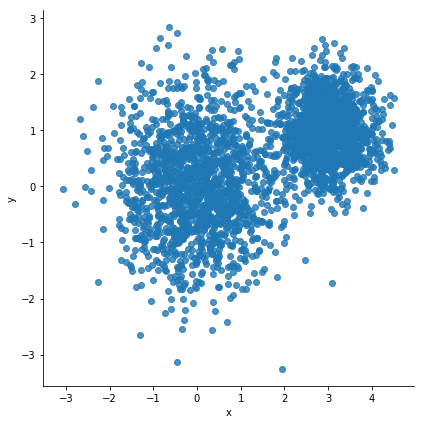

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"x":[v[0] for v in vectors_set], "y":[v[1] for v in vectors_set]})
sns.lmplot("x","y", data=df, fit_reg=False, size = 6 )
plt.show()

In [7]:
import tensorflow as tf

vectors = tf.constant(vectors_set) # 위에서 만든 데이터를 텐서화(상수 텐서)

k = 10 # 4개군으로
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors),[0,0],[k,-1])) # 초기단계(0단계), 입력 데이터를 무작위로 섞어서 K개의 중심을 선택
# k개의 데이터 포인트는 2D 텐서로 저장.

# 알고리즘 : 루프 반복 - 각 점에 대해 유클리드 제곱 거리(squared Euclidean distance) 여러 거리 사이의 대소 비교 시 사용 (실 거리 아님)
# 그런데 tf.subtract(vectors, centroids)를 하려고 하니, D0 차원의 크기가 서로 다름.
# tf.expand_dims 를 사용 : 2차원에서 3차원으로 만들어 뺄셈을 할 수 있게 함.
expanded_vectors = tf.expand_dims(vectors,0)
expanded_centroids = tf.expand_dims(centroids,1)

# vectors 는 D0 추가 | centroids 는 D1 추가
# 따라서 두 텐서는 3차원으로 같다. (뺄셈 가능)

"""
쉽게 정리하면

vectors 에서 D0차원이 2000이고 centroids의 D0차원이 4여서 계산 불가.
따라서 vectors에 D0을 추가하고 centroids에 D1을 추가한다.
이때, 
                    [ D0  ,   D1  ,   D2  ]
expanded_vectors : ([D(1), D(2000), D(2)]) -> expanded_vectors D2의 크기는 centroids의 D0인 (1,2,3,4)와 동일한 4
expanded_centroids : ([D(1), D(2000), D(2)]) -> expanded_centroids D1의 크기는 vectors의 D0인 (1,2,3....2000) 과 동일한 2000

따라서 전체적인 크기는 동일하다. (메트릭스로 생각하자!)
"""

# 유클리드 제곱거리를 사용하는 할당 단계(1단계)의 알고리즘
assignments = tf.argmin(tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)),2),0)
"""
위 공식인 유클리드 제곱거리를 풀어서 생각하면,

diff = tf.subtract(expanded_vectors, expanded_centroids)
sqr = tf.square(diff)
distance = tf.recude_sum(sqr,2)
assignments = tf.argmin(distance,0)

"""


# 마지막 수정단계(2단계) : 반복 시행. 따라서 매 반복마다 새롭게 그룹화를 하면서 각 그룹에 해당하는 새로운 중심을 다시 계산
means = tf.concat([tf.reduce_mean(tf.gather(vectors,tf.reshape(tf.where(tf.equal(assignments,c)), [1,-1])), reduction_indices=[1]) for c in xrange(k)], 0)
"""
위 코드는 K개 군집에 속하는 점들의 평균을 가진 K개의 텐서를 합쳐서 meand 텐서를 만듬.
1) 먼저 equal 함수를 사용하여 한 군집과 매칭되는(여기서는 c) assignments 텐서의 각 원소 위치를 True로 표시하는 불리언텐서(D(2000))을 생성
2) where 함수를 사용, 매개변수로 받은 불리언텐서(D(2000))에서 True로 표시된 위치를 값으로 가지는 텐서(D(2000)*D(1)) 생성
3) reshape 함수를 사용, c 군집에 속한 vectors 텐서의 포인트들의 인덱스로 구성된 텐서(D(1)* D(2000)) 생성
4) gather 함수를 사용, C 군집을 이루는 점들의 좌표를 모은 텐서(D(1)*D(2000)*D(2)) 생성
5) reduce_mean 함수를 사용하여 c 군집에 속한 모든 점의 평균 값을 가진 텐서(D(1)*D(2)) 생성
"""

# 마지막으로 위에서 생성한 텐서(mean)로 중심을 업데이트 (means 텐서의 값을 centroids에 할당하는 연산을 작성)
update_centroids = tf.assign(centroids, means)
# 그래야 run() 메서드가 실행될 때 업데이트 된 중심값이 다음번 루프에서 사용될 수 있기 때문에

# 이 때까지 사용한 모든 변수를 초기화
init_op = tf.global_variables_initializer()


# 실행
sess = tf.Session()
sess.run(init_op)

for step in xrange(100):
    # 각 작업에 대해 매개변수 할당, 배열로 리턴하게끔. update_centroids 연산은 리턴값이 없으므로 _ 표시(버림)
    _, centroid_values, assignment_values = sess.run([update_centroids,centroids,assignments])

print centroid_values

[[ 3.55865765  0.99228466]
 [ 2.54527855  0.99003243]
 [ 1.53852081  0.26590309]
 [-1.00952876  1.09367836]
 [ 0.26623121  0.8853789 ]
 [ 2.95014071  1.60122669]
 [ 3.0092392   0.34427238]
 [-0.22689959 -1.32994485]
 [ 0.56869096 -0.43137002]
 [-0.89654821 -0.18752456]]


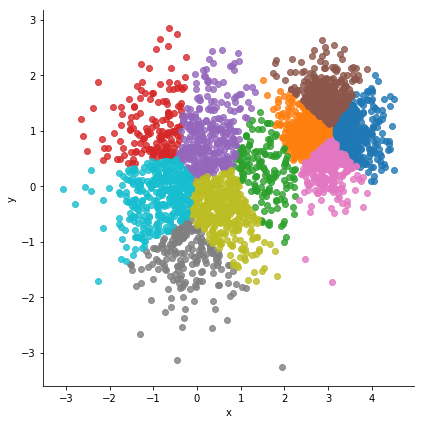

In [13]:
data = {"x":[],"y":[],"cluster":[]}

for i in xrange(len(assignment_values)):
    data["x"].append(vectors_set[i][0])
    data["y"].append(vectors_set[i][1])
    data["cluster"].append(assignment_values[i])

df = pd.DataFrame(data)
sns.lmplot("x","y",data=df, fit_reg=False, size=6, hue="cluster", legend=False)
plt.show()


In [42]:
vectors.get_shape()  # 텐서 구조 확인하는 것. : D0 차원은 크기가 2000개이고, D1 차원은 크기가 2 (각 점의 좌표 x , y)

TensorShape([Dimension(3000), Dimension(2)])

In [43]:
centroids.get_shape() # centroidssms D0 차원은 크기가 4, D1 차원은 vectors와 동일

TensorShape([Dimension(10), Dimension(2)])

In [44]:
expanded_vectors.get_shape()

TensorShape([Dimension(1), Dimension(3000), Dimension(2)])

In [45]:
expanded_centroids.get_shape()

TensorShape([Dimension(10), Dimension(1), Dimension(2)])

In [46]:
diff = tf.subtract(expanded_vectors, expanded_centroids)
sqr = tf.square(diff)
distance = tf.reduce_sum(sqr,2)
assignments = tf.argmin(distance,0)



In [47]:
diff.get_shape() # 단순 각 차원별 뺄셈이라 크기는 변하지 않음

TensorShape([Dimension(10), Dimension(3000), Dimension(2)])

In [48]:
sqr.get_shape() #단순 제곱한 것. (유클리드 제곱거리 생각할 것 - 각 차원 별로 빼고, 그 값을 제곱해서 더함)

TensorShape([Dimension(10), Dimension(3000), Dimension(2)])

In [51]:
distance.get_shape() # 여기서 차원이 줄어듬.(D2) - D0 차원을 보면 크기가 4개로 , 중심값이 존재함
# """
# tf.reduce_sum : 지정한 차원을 따라 원소들을 더함
# tf.reduce_prod : 지정한 차원을 따라 원소들을 곱함
# tf.reduce_min : 지정한 차원을 따라 최솟값을 계산
# tf.reduce_max : 지정한 차원을 따라 최댓값을 계산
# tf.reduce_mean : 지정한 차원을 따라 평균을 계산
# """

TensorShape([Dimension(10), Dimension(3000)])

In [52]:
assignments.get_shape() # 마지막으로 지정한 차원(여기서는 중심값이 있는 D0 차원)

# """
# tf.argmin : 지정한 차원을 따라 가장 작은 값의 원소가 있는 인덱스 리턴
# tf.argmax : 지정한 차원을 따라 가장 큰 값의 원소가 있는 인덱스 리턴
# """

TensorShape([Dimension(3000)])